In [1]:
import sys
sys.path.append("../")

In [2]:
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.random import set_seed
import tensorflow.keras.backend as K
from tensorflow.keras import activations

from tensorflow.keras.layers import (
    Input,
    Activation,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    ELU,
    LeakyReLU,
    MaxPool2D,
    PReLU
)

from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

WIDTH, HEIGHT = (256, 256)
BATCH_SIZE = 4
DATAGEN_SEED = 24
NUM_CLASSES = 29

set_seed(DATAGEN_SEED)

2024-01-13 16:58:27.739495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_dir, val_dir = "../cityscapes_data_preprocessed/train/", "../cityscapes_data_preprocessed/val/"
training_images_num, val_images_num = len(os.listdir(train_dir + "img/dummy/")), len(os.listdir(val_dir + "img/dummy/"))
training_images_num, val_images_num

(2972, 500)

In [4]:
from tensorflow.data import Dataset

img_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator()

train_image_datagen = img_datagen.flow_from_directory(train_dir + "img/", class_mode=None, batch_size=BATCH_SIZE, seed=DATAGEN_SEED)
train_mask_datagen = mask_datagen.flow_from_directory(train_dir + "mask/", class_mode=None, batch_size=BATCH_SIZE, seed=DATAGEN_SEED, color_mode="grayscale")
train_mask_generator = Dataset.from_generator(lambda: train_mask_datagen,
    output_types=tf.float32,
    output_shapes=(BATCH_SIZE, 256, 256, 1)
).map(lambda x: tf.reshape(tf.one_hot(tf.cast(x, tf.uint8), depth=NUM_CLASSES), (BATCH_SIZE, 256, 256, NUM_CLASSES)))
train_set = zip(train_image_datagen, train_mask_generator)

val_image_datagen = img_datagen.flow_from_directory(val_dir + "img/", class_mode=None, batch_size=BATCH_SIZE, seed=DATAGEN_SEED)
val_mask_datagen = mask_datagen.flow_from_directory(val_dir + "mask/", class_mode=None, batch_size=BATCH_SIZE, seed=DATAGEN_SEED, color_mode="grayscale")
val_mask_generator = Dataset.from_generator(lambda: val_mask_datagen,
    output_types=tf.float32,
    output_shapes=(BATCH_SIZE, 256, 256, 1)
).map(lambda x: tf.reshape(tf.one_hot(tf.cast(x, tf.uint8), depth=NUM_CLASSES), (-1, 256, 256, NUM_CLASSES)))
val_set = zip(val_image_datagen, val_mask_generator)

Found 2972 images belonging to 1 classes.
Found 2972 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.


2024-01-13 16:58:29.534858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:58:29.538478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:58:29.538663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:58:29.539571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-13 16:58:29.539748: I tensorflow/compile

In [5]:
def dice_coef(y_true, y_pred, num_classes=29):
    smooth = 1e-15
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [5]:
def modulus_activation(x):
    return K.abs(x)

In [5]:
kernel_initializer =  'he_uniform'

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer=kernel_initializer)(inputs)
    x = BatchNormalization()(x)
    # x = PReLU()(x)
    x = LeakyReLU()(x)
    # x = Activation(modulus_activation)(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer=kernel_initializer)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # x = Activation(activations.gelu)(x)
    
    # x = Activation(modulus_activation)(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same", kernel_initializer=kernel_initializer)(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes=29):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    # s4, p4 = encoder_block(p3, 512)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    # d1 = decoder_block(b1, s4, 512)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(NUM_CLASSES, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

In [6]:
model = build_unet((HEIGHT, WIDTH, 3))
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=['accuracy', Recall(name="recall"), Precision(name="precision")])

In [7]:
callbacks = [
    ModelCheckpoint(filepath="../models/cityscapes/leaky_relu_model.hdf5",
                    monitor="val_loss",
                    save_best_only=True),
    EarlyStopping(monitor="val_loss",
                  patience=5,
                  min_delta=0.01,
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss",
                      factor=0.1,
                      min_delta=0.01,
                      patience=2,
                      verbose=1,
                      min_lr=1e-6)
]

In [8]:
history = model.fit(train_set,
                    validation_data=val_set,
                    epochs=300,
                    callbacks=callbacks,
                    steps_per_epoch=training_images_num // BATCH_SIZE,
                    validation_steps=val_images_num // BATCH_SIZE)

Epoch 1/300


2024-01-13 16:59:15.019696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-13 16:59:17.795837: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4d4c37fec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-13 16:59:17.795873: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-01-13 16:59:17.799467: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-13 16:59:17.888670: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-01-13 16:59:24.043160: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The call

743/743 [==============================] - ETA: 0s - loss: 1.0974 - accuracy: 0.7060 - recall: 0.6132 - precision: 0.8106

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


743/743 [==============================] - 108s 125ms/step - loss: 1.0974 - accuracy: 0.7060 - recall: 0.6132 - precision: 0.8106 - val_loss: 1.2063 - val_accuracy: 0.6997 - val_recall: 0.6684 - val_precision: 0.7448 - lr: 0.0010
Epoch 2/300
743/743 [==============================] - 92s 124ms/step - loss: 0.8707 - accuracy: 0.7622 - recall: 0.6980 - precision: 0.8438 - val_loss: 0.9757 - val_accuracy: 0.7303 - val_recall: 0.6641 - val_precision: 0.8138 - lr: 0.0010
Epoch 3/300
743/743 [==============================] - 92s 124ms/step - loss: 0.8018 - accuracy: 0.7835 - recall: 0.7256 - precision: 0.8602 - val_loss: 0.8075 - val_accuracy: 0.7858 - val_recall: 0.7387 - val_precision: 0.8536 - lr: 0.0010
Epoch 4/300
743/743 [==============================] - 93s 125ms/step - loss: 0.7489 - accuracy: 0.7975 - recall: 0.7432 - precision: 0.8708 - val_loss: 0.7889 - val_accuracy: 0.7851 - val_recall: 0.7395 - val_precision: 0.8541 - lr: 0.0010
Epoch 5/300
743/743 [==========================

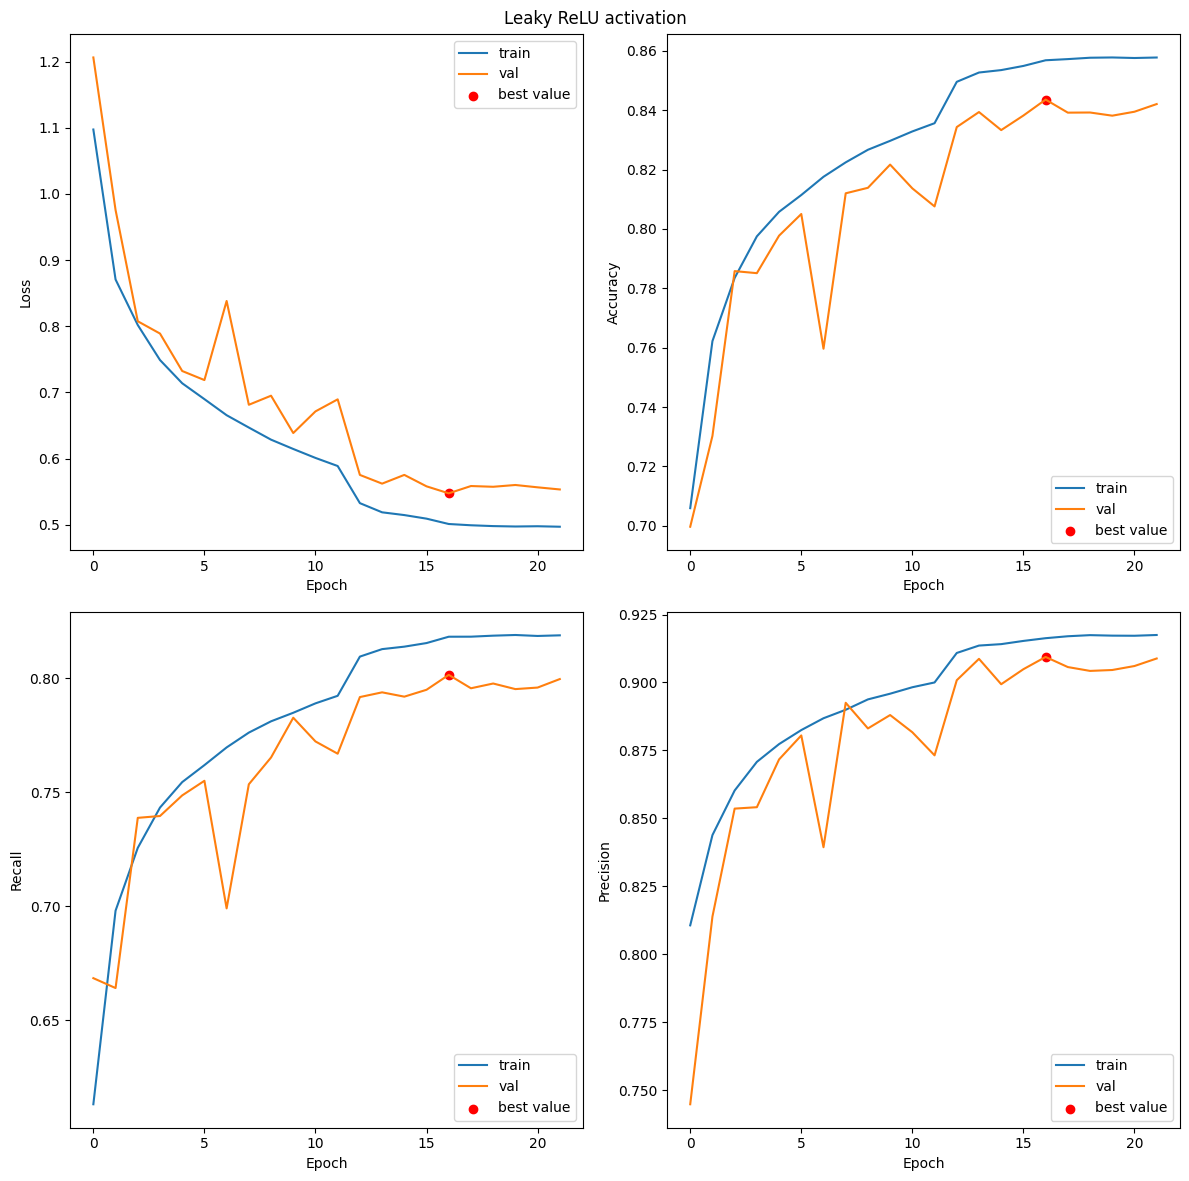

In [9]:
import matplotlib.pyplot as plt

best_epoch = 16

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.suptitle("Leaky ReLU activation")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.scatter(best_epoch, history.history['val_loss'][best_epoch], c='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val', 'best value'], loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.scatter(best_epoch, history.history['val_accuracy'][best_epoch], c='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val', 'best value'], loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.scatter(best_epoch, history.history['val_recall'][best_epoch], c='r')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['train', 'val', 'best value'], loc='lower right')

plt.subplot(2, 2, 4)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.scatter(best_epoch, history.history['val_precision'][best_epoch], c='r')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['train', 'val', 'best value'], loc='lower right')

plt.tight_layout()
# plt.show()
plt.savefig("../plots/cityscapes/leaky_relu.pdf")